In [32]:
import gymnasium
import random
import gymnasium_env
import numpy as np
from collections import defaultdict
from gymnasium_env.envs.grid_world import Actions
import matplotlib.pyplot as plt
grid_size = 20
env = gymnasium.make('gymnasium_env/GridWorld-v0', size = grid_size)

**Simple Reward: reach target = 1 else 0**

In [33]:
class Qlearning:
    def __init__(self, env, epsilon, learning_rate = 0.1, discount_factor = 0.9, q_table_old = None):
        self.env = env
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.episode_reward = []
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        self.q_table_old = q_table_old
        self.sample_4_actions = set()
        self.rng = np.random.default_rng(123)
   
    def train(self, number_episode, max_step):
        EPS_START, EPS_END, EPS_DECAY_EPISODES = 1.0, 0.05, 300
        eps = EPS_START
        eps_decay = (EPS_START - EPS_END) / max(1, EPS_DECAY_EPISODES)
        for ep in range(number_episode):
            observation, _ = self.env.reset()
            current_state = tuple(observation['agent']) # convert to tuple to make sure it is hashable
            target_pos = observation['target']
            #print(f'agent start point {current_state}, target = {target_pos}')
            done = False
            step = 0
            total_reward = 0
            while not done and step < max_step:
                self.sample_4_actions.add(current_state)
                # choose the action you want to move
                action = self.get_action(current_state, self.q_table, eps)
                # move that action
                next_observation, reward, done, _, _ = self.env.step(action)
                next_state = tuple(next_observation['agent'])
                target = reward if done else reward + self.discount_factor * np.max(self.q_table[next_state])
                self.q_table[current_state][action] += self.learning_rate * (target - self.q_table[current_state][action])
                current_state = next_state
                total_reward += self.discount_factor * reward
                step += 1
            self.episode_reward.append(total_reward)
            if ep < EPS_DECAY_EPISODES:
                eps = max(EPS_END, eps - eps_decay)
    
    def get_action(self, current_state, q_table, epsilon):
        if self.rng.random() < epsilon:
            action = int(self.rng.integers(self.env.action_len()))
        else:
            action = np.argmax(q_table[current_state])
        return action
    
    def adaptive_train(self, number_episode, max_step):
        EPS_START, EPS_END, EPS_DECAY_EPISODES = 1.0, 0.05, 300
        eps = EPS_START
        eps_decay = (EPS_START - EPS_END) / max(1, EPS_DECAY_EPISODES)
        
        for ep in range(number_episode):  # Changed from _ to ep
            observation, _ = self.env.reset()
            current_state = tuple(observation['agent'])
            done = False
            step = 0
            total_reward = 0
            while not done and step < max_step:
                action = self.get_action(current_state, self.q_table, eps)  # Added eps parameter
                if action == Actions.diagonal_down_right.value:
                    # Preview the next state without taking the action
                    next_state_preview = tuple(self.env.check_next_state_of_action(action))
                    if np.max(self.q_table[current_state]) > np.max(self.q_table[next_state_preview]):  # Fixed condition
                        action = self.get_action(current_state, self.q_table_old, eps)  # Added eps parameter
                
                next_observation, reward, done, _, _ = self.env.step(action)
                next_state = tuple(next_observation['agent'])
                target = reward if done else reward + self.discount_factor * np.max(self.q_table[next_state])
                self.q_table[current_state][action] += self.learning_rate * (target - self.q_table[current_state][action])
                current_state = next_state
                total_reward += self.discount_factor * reward
                step += 1
            
            self.episode_reward.append(total_reward)
            if ep < EPS_DECAY_EPISODES:
                eps = max(EPS_END, eps - eps_decay)

    def reset_to_new_action(self, new_action_direction):
        self.env.reset_to_new_action(new_action_direction)
    
        
    def sample_for_new_action(self, new_action):
        self.env.reset()
        for current_state in self.sample_4_actions:
            observation = self.env.teleport(to_state = current_state)
            print(observation)
            next_observation, reward, _, _, _ = self.env.step(new_action)
            next_state = tuple(next_observation['agent'])
            if np.max(self.q_table[current_state]) < np.max(self.q_table[next_state]):
                self.q_table[current_state][new_action] += self.learning_rate * (reward + self.discount_factor * np.max(self.q_table[next_state]) - self.q_table[current_state][new_action])
    
    def expand_qtable_actions(self, default_new_value):
        for state in self.q_table.keys():
            self.q_table[state] = np.append(self.q_table[state], default_new_value)
            
    def get_optimal_policy(self):
        policy = {}
        for state in self.q_table.keys():
            # Get the action with highest Q-value for each state
            optimal_action = np.argmax(self.q_table[state])
            policy[state] = optimal_action
        return policy
    
    def moving_average(self, w=20):
        if len(self.episode_reward) < w:
            return self.episode_reward.copy()
        return np.convolve(self.episode_reward, np.ones(w)/w, mode='valid')

    def evaluate_policy(self, q_table, num_episodes = 10, max_steps = 200):
        """evaluate policy for a given q_table"""
        total_rewards = []
        
        for _ in range(num_episodes):
            observation, _ = self.env.reset()
            current_state = tuple(observation['agent'])
            done = False
            step = 0
            episode_reward = 0
            path = [current_state]  # Track the path taken
            
            while not done and step < max_steps:
                # follow the policy (no exploration)
                if current_state in self.q_table:
                    action = np.argmax(self.q_table[current_state])
                else: # this could be happen because you didn't train enough
                    action = self.env.action_space.sample()
                # explore new action
                next_observation, reward, done, _, _ = self.env.step(action)
                next_state = tuple(next_observation['agent'])
                current_state = next_state
                episode_reward += reward
                step += 1
                path.append(current_state)
            
            total_rewards.append(episode_reward)
        
        avg_reward = np.mean(total_rewards)
        return avg_reward, total_rewards
    
    def evaluate_policy_with_new_action(self, new_action, num_episodes):
        total_rewards = []
        
        for _ in range(num_episodes):
            observation, _ = self.env.reset()
            current_state = tuple(observation['agent'])
            done = False
            step = 0
            episode_reward = 0
            while not done and step < max_step:
                if current_state in self.q_table:
                    action = np.argmax(self.q_table[current_state])
                else:
                    action = self.env.action_space.sample()
                # this is assumption that we have T function
                state_of_diagonal_action = tuple(self.env.check_next_state_of_action(new_action))
                if np.argmax(self.q_table[state_of_diagonal_action]) > np.argmax(self.q_table[current_state]):
                    action = new_action
                next_observation, reward, done, _, _ = self.env.step(action)
                next_state = tuple(next_observation['agent'])
                current_state = next_state
                episode_reward += reward
                step += 1
            total_rewards.append(episode_reward)
        return np.mean(total_rewards), total_rewards     

    def visualize_policy(self, policy, grid_size):
        """Visualize the policy as a grid with action arrows"""
        action_symbols = {
            0: '↓',  # down
            1: '→',  # right  
            2: '↑',  # up
            3: '←',  # left
            4: '↘'   # diagonal_down_right (if available)
        }
        
        print("Optimal Policy Visualization:")
        print("Grid shows the optimal action for each state")
        
        for row in range(grid_size):
            line = ""
            for col in range(grid_size):
                state = (row, col)
                if state in policy:
                    action = policy[state]
                    max_q_value = f"{np.max(self.q_table[state]):.2f}"
                    symbol = action_symbols.get(action, str(action)) + "(" + max_q_value + ")"
                else:
                    symbol = '?'  # State not visited during training
                line += f"{symbol:^3}"
            print(line)
        print()
   
        
# 5 actions 
train_episode = 600
max_step = 200
q_learning_5_action = Qlearning(env, 0.1, 0.9, 0.9)
new_action_direction = {
            Actions.right.value: np.array([1, 0]),
            Actions.up.value: np.array([0, 1]),
            Actions.left.value: np.array([-1, 0]),
            Actions.down.value: np.array([0, -1]),
            Actions.diagonal_down_right.value: np.array([1, 1])
        }    
q_learning_5_action.reset_to_new_action(new_action_direction)
q_learning_5_action.train(train_episode, max_step)
# only 4 action
#4 action for Q-learing
new_env_4_action = gymnasium.make('gymnasium_env/GridWorld-v0', size = grid_size)
q_learning_4_action = Qlearning(new_env_4_action, 0.1, 0.9, 0.9)
q_learning_4_action.train(train_episode, max_step)

q_learning_adaptive = Qlearning(env, 0.1, 0.9, 0.9, q_learning_4_action.q_table)
new_action_direction = {
            Actions.right.value: np.array([1, 0]),
            Actions.up.value: np.array([0, 1]),
            Actions.left.value: np.array([-1, 0]),
            Actions.down.value: np.array([0, -1]),
            Actions.diagonal_down_right.value: np.array([1, 1])
        }    
q_learning_adaptive.reset_to_new_action(new_action_direction)
q_learning_adaptive.adaptive_train(train_episode, max_step)


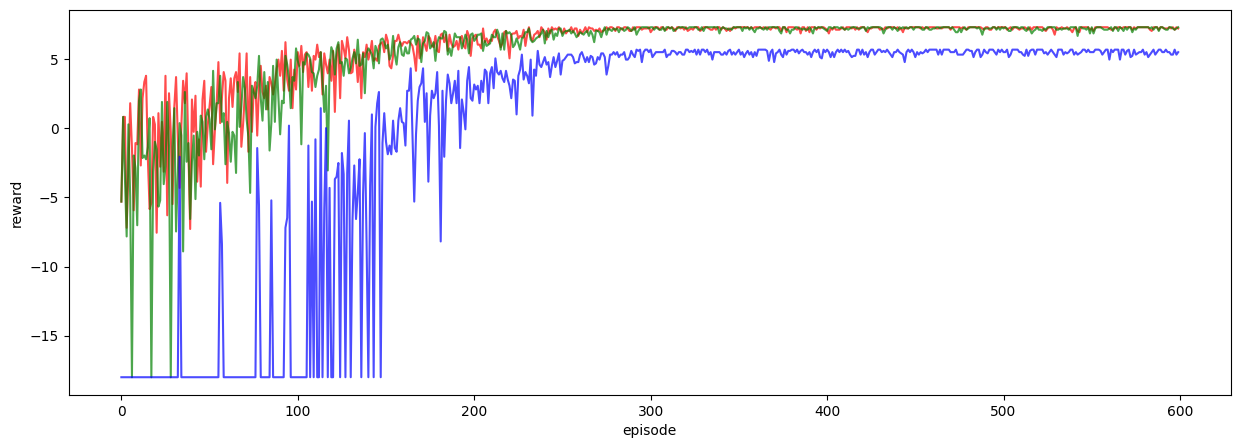

In [34]:

plt.figure(figsize= (15, 5))
plt.plot(q_learning_5_action.episode_reward, label = "base reward with 5 action", alpha = 0.7, color = "red")
plt.plot(q_learning_adaptive.episode_reward, label = "adaptive learning (4 + 1) actions", alpha = 0.7, color = "green")
plt.plot(q_learning_4_action.episode_reward, label = "only 4 action", alpha = 0.7, color = 'blue')
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

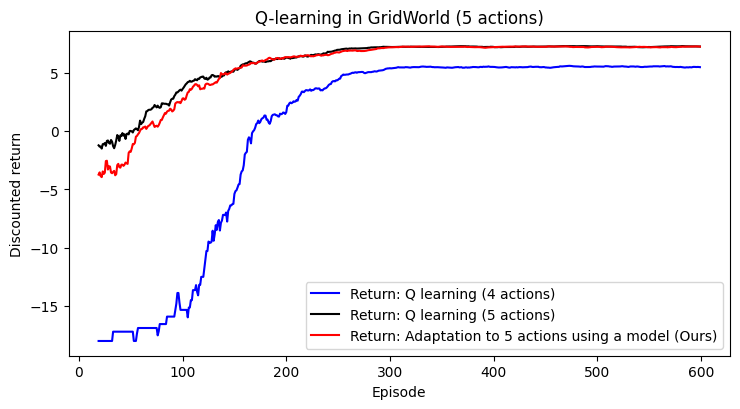

In [35]:
plt.figure(figsize=(7.5, 4.2))
plt.plot(np.arange(len(q_learning_4_action.episode_reward))[-len(q_learning_4_action.moving_average()):], q_learning_4_action.moving_average(), 'b', label='Return: Q learning (4 actions)')
plt.plot(np.arange(len(q_learning_5_action.episode_reward))[-len(q_learning_5_action.moving_average()):], q_learning_5_action.moving_average(), 'k', label='Return: Q learning (5 actions)')
plt.plot(np.arange(len(q_learning_adaptive.episode_reward))[-len(q_learning_adaptive.moving_average()):], q_learning_adaptive.moving_average(), 'r', label='Return: Adaptation to 5 actions using a model (Ours)')
plt.xlabel('Episode')
plt.ylabel('Discounted return')
plt.title('Q-learning in GridWorld (5 actions)')
plt.legend()
plt.tight_layout()
plt.show()